## Question 1
The goal is to analyze the FAA Wildlife Strike Database to identify patterns and trends in wildlife
strikes to civil aircraft. We must clean and reduce the dataset to only include relevant features for
the analysis. We must examine factors such as aircraft type, wildlife involved, location, and time.
After extracting factors like these we perform statistical tests, test hypotheses, and create visualizations
to help reduce the occurance and impact of wildlife strikes on civil aircraft in the future.

## Question 2

Load the data using pandas and inspect it.

Perform the initial inspection of the data, its shape, types, etc.

Evaluate the dataset and perform at least three type of data preparation and justify the approach that is taken to prepare the data for analysis. Data prep can include, but is not limited to: handling missing values, data types, duplicates, etc. You will need to ensure that your data preparation addressed issues in at least 7 fields in the data.

Prepare meaningful* summary statistics for 3 continuous variables and 3 categorical variables.
Note: meaningful summary statistics explains the statistical summary of relevant fields in a coherent manner.

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sns
from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import skew

data = pd.read_csv("Bird_Strikes_1990_2023.csv")
data

FileNotFoundError: [Errno 2] No such file or directory: 'Bird_Strikes_1990_2023.csv'

In [ ]:
data.dtypes

In [ ]:
data.info(verbose=True)

In [ ]:
print("\nMissing values per column (top 10):")
print(data.isnull().sum().sort_values(ascending=False).head(10))

In [ ]:
# fix categories 
data.info(verbose=True)

In [ ]:
# Identify object-type columns (potential categorical variables)
cat_cols = data.select_dtypes(include='object').columns
print("Possible categorical fields:", len(cat_cols))
print(cat_cols.tolist())


In [ ]:
data = data.copy()
# standardize
for col in cat_cols:
    data[col] = data[col].astype(str).str.strip()
    data[col] = data[col].replace(['nan', 'NaN', 'None', 'UNKNOWN', 'Unknown'], np.nan)

# normalize text capitalization for key fields
data['STATE'] = data['STATE'].str.upper()
data['AIRPORT'] = data['AIRPORT'].str.title()
data['SPECIES'] = data['SPECIES'].str.title()
data['OPERATOR'] = data['OPERATOR'].str.title()
data['PHASE_OF_FLIGHT'] = data['PHASE_OF_FLIGHT'].str.title()
data['TIME_OF_DAY'] = data['TIME_OF_DAY'].str.title()
data['SIZE'] = data['SIZE'].str.title()
data['WARNED'] = data['WARNED'].str.capitalize()

for col in ['STATE', 'AIRPORT', 'SPECIES', 'PHASE_OF_FLIGHT', 'TIME_OF_DAY', 'SIZE']:
    data[col] = data[col].fillna('Unknown')

# convert them to category dtype 
for col in cat_cols:
    data[col] = data[col].astype('category')

# take care of dates and times 
data['TIME'] = pd.to_datetime(data['TIME'], format='%H:%M', errors='coerce').dt.time

data['INCIDENT_DATE'] = pd.to_datetime(data['INCIDENT_DATE'], errors='coerce')

data

In [ ]:
# check changes 
data.info(verbose=True)

In [ ]:
data

In [ ]:
# handling null values 
# if a column is missing more than 50% of the data, then remove it 
threshold = len(data) * 0.5
data = data.dropna(thresh=threshold, axis=1)
print("Remaining columns:", data.shape[1])

In [ ]:
data

In [ ]:
# check for duplicates 
data.duplicated().sum()

In [ ]:
data['TIME_OF_DAY'].unique()

In [ ]:
# the data has unkonws for time of day even though the the time is known. 
# Here I define times of the day to the unique categoires of the time of day (dawn,day,dusk,etc.) 
# to add values in the data that we can directly infer all while maintaining integrity
data = data.copy()


def infer_time_of_day(t):
    if pd.isna(t):
        return np.nan
    h = t.hour
    if 5 <= h < 7:
        return 'Dawn'
    elif 7 <= h < 18:
        return 'Day'
    elif 18 <= h < 20:
        return 'Dusk'
    else:
        return 'Night'


# Create a new inferred column from TIME
data['TIME_OF_DAY_INFERRED'] = data['TIME'].apply(infer_time_of_day)

# Replace 'Unknown' only where TIME_OF_DAY is missing or 'Unknown'
mask = (data['TIME_OF_DAY'] == 'Unknown') & data['TIME_OF_DAY_INFERRED'].notna()
data.loc[mask, 'TIME_OF_DAY'] = data.loc[mask, 'TIME_OF_DAY_INFERRED']

# Drop helper column
data.drop(columns='TIME_OF_DAY_INFERRED', inplace=True)


In [ ]:
data

In [ ]:
data.describe()

In [ ]:
data.columns

In [ ]:
data.isna().sum()

Question 4 — Hypothesis Testing (30 points)

Perform pairwise analysis of select features and evaluate the significance of the pattern or trend. A suitable value for alpha is 5%. Explain all results.

Create a scatterplot that shows the relationship between aircraft height and speed. Evaluate the correlation, the strength and the significance of the results.
Visualize the distribution of the aircraft speed during: 1) the approach phase of flight and 2) the landing roll phase of flight. Perform a 2 sample t-test and evaluate if there is a statistical difference between the speed during these two flight phases. Tip: if the data is skewed, you will need to address this prior to the statistical analysis.
Create a visualization of the aircraft damage grouped by phase of flight.
Evaluate if the results are statistically significant. Ensure that you use the appropriate test.
Perform ONE (1) additional statistical test.
Explain what you are testing and the reason this information is useful.
Visualize the data, state the hypothesis and explain if it is statistically significant.


In [6]:
sns.set(style="whitegrid")
alpha = 0.05
df = data.copy()
# Normalize
for col in ['PHASE_OF_FLIGHT', 'TIME_OF_DAY']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.title()
if 'SPEED' in df.columns:
    df['SPEED'] = pd.to_numeric(df['SPEED'], errors='coerce')
if 'HEIGHT' in df.columns:
    df['HEIGHT'] = pd.to_numeric(df['HEIGHT'], errors='coerce')
# Part 1
if 'HEIGHT' in df.columns and 'SPEED' in df.columns:
    pair = df[['HEIGHT', 'SPEED']].dropna()
    if len(pair) > 5:
      plt.figure(figsize=(8, 6))
    sns.scatterplot(x='HEIGHT', y='SPEED', data=pair, alpha=0.5)
    plt.title('Scatterplot: Aircraft Height vs Speed')
    plt.xlabel('Height (ft)')
    plt.ylabel('Speed (knots)')
    plt.tight_layout()
    plt.show()
    # Coefficients
    pearson_r, pearson_p = stats.pearsonr(pair['HEIGHT'], pair['SPEED'])
    print(f"Pearson r = {pearson_r:.4f}, p = {pearson_p:.4g}")
    print("Interpretation:",
          "Strong correlation." if abs(pearson_r) > 0.5 else
          "Moderate correlation." if abs(pearson_r) > 0.3 else
          "Weak or negligible correlation.")
    if pearson_p < alpha:
        print("Result: Statistically significant relationship (p < 0.05).")
    else:
        print("Result: No statistically significant correlation (p ≥ 0.05).")
# Part 2
phases = ['Approach', 'Landing Roll']
q2 = df[df['PHASE_OF_FLIGHT'].isin(phases)].copy()
gA = q2[q2['PHASE_OF_FLIGHT'] == 'Approach']['SPEED'].dropna()
gL = q2[q2['PHASE_OF_FLIGHT'] == 'Landing Roll']['SPEED'].dropna()
print(f"Counts — Approach: {len(gA)}, Landing Roll: {len(gL)}")
# Calculate skewness
skew_approach = skew(gA)
skew_landing = skew(gL)
print(f"Skewness — Approach: {skew_approach:.3f}")
print(f"Skewness — Landing Roll: {skew_landing:.3f}")
# Visual 1: Histogram
plt.figure(figsize=(9, 5))
sns.histplot(gA, bins=30, stat='density', alpha=0.45, label='Approach', kde=True)
sns.histplot(gL, bins=30, stat='density', alpha=0.45, label='Landing Roll', kde=True)
plt.title('Distribution of SPEED: Approach vs Landing Roll')
plt.xlabel('Speed (knots)')
plt.legend()
plt.tight_layout()
plt.show()
# Visual 2: Boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(x='PHASE_OF_FLIGHT', y='SPEED', data=q2, order=['Approach', 'Landing Roll'])
plt.title('SPEED by Phase of Flight')
plt.xlabel('Phase of Flight')
plt.ylabel('Speed (knots)')
plt.tight_layout()
plt.show()
# 2-sample t-test
if len(gA) >= 2 and len(gL) >= 2:
    t_stat, p_val = stats.ttest_ind(gA, gL, equal_var=False, nan_policy='omit')
    print(f"T-test: t = {t_stat:.4f}, p = {p_val:.4g}")
    print(f"Means — Approach: {gA.mean():.2f}, Landing Roll: {gL.mean():.2f}")
    print("Conclusion:",
          "Significant difference (p < 0.05)." if p_val < alpha else "No significant difference (p ≥ 0.05).")
# Part 3
# Determine damage column
damage_col = None
if 'DAMAGE_LEVEL' in df.columns:
    damage_col = 'DAMAGE_LEVEL'
elif 'INDICATED_DAMAGE' in df.columns:
    damage_col = 'INDICATED_DAMAGE'
else:
    dam_cols = [c for c in df.columns if c.upper().startswith('DAM_')]
    if dam_cols:
        df['DamageFlag'] = df[dam_cols].notnull().any(axis=1)
    damage_col = 'DamageFlag'
if damage_col:
    cont = pd.crosstab(df['PHASE_OF_FLIGHT'], df[damage_col], dropna=False)
    prop = cont.div(cont.sum(axis=1), axis=0)
    # Visual: stacked proportion bar
    ax = prop.plot(kind='bar', stacked=True, figsize=(10, 6))
    ax.set_title(f'Damage ({damage_col}) by Phase of Flight')
    ax.set_ylabel('Proportion')
    plt.legend(title=damage_col, bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    # Chi-square test
    chi2, pchi, dof, exp = stats.chi2_contingency(cont.fillna(0))
    n_total = cont.values.sum()
    cramers_v = np.sqrt(chi2 / (n_total * (min(cont.shape) - 1)))
    print(f"Chi-square = {chi2:.4f}, p = {pchi:.4g}, dof = {dof}")
    print(f"Cramer's V = {cramers_v:.4f}")
    print("Conclusion:",
          "Significant association (p < 0.05)." if pchi < alpha else "No significant association(p ≥ 0.05).")
else:
    print("No damage column found — cannot perform Q3.")
    # Part 4
    if 'TIME_OF_DAY' in df.columns and (damage_col or 'DamageFlag' in df.columns):
        dmg_col = damage_col if damage_col else 'DamageFlag'
    cont4 = pd.crosstab(df['TIME_OF_DAY'], df[dmg_col])
    # Visual: Proportion by time of day
    prop4 = cont4.div(cont4.sum(axis=1), axis=0)
    ax = prop4.plot(kind='bar', stacked=True, figsize=(9, 6))
    ax.set_title(f'Damage Presence by Time of Day ({dmg_col})')
    ax.set_ylabel('Proportion')
    plt.xticks(rotation=25, ha='right')
    plt.tight_layout()
    plt.show()
    # Chi-square test of independence
    chi4, p4, dof4, exp4 = stats.chi2_contingency(cont4.fillna(0))
    n4 = cont4.values.sum()
    cramers_v4 = np.sqrt(chi4 / (n4 * (min(cont4.shape) - 1)))
    print(f"Chi-square = {chi4:.4f}, p = {p4:.4g}, dof = {dof4}")
    print(f"Cramer's V = {cramers_v4:.4f}")
    print("Conclusion:",
          "Significant association (p < 0.05)." if p4 < alpha else "No significant relationship(p ≥ 0.05).")

SyntaxError: unterminated string literal (detected at line 68) (4241002089.py, line 68)

Question 4 Analysis:
1. Here we created a scatterplot that shows the relationship between height of the aircraft in feet
and speed of the aircraft in knots during recorded striks. We want to see if the two variables are
related and have any correlation. To do this, we conducted a t-test using the pearson r coefficient.
Through a python statistics package we calculated an r value between the two variables of
0.6960. We then transformed this into a t-test using sample size and degrees of freedom. From
that we got a p value of extremely close to zero or just zero. This is less than the alpha of 5%
which means the variables are statistically significant and there is a strong correlation. In
non-statistical words, height and speed of aircrafts during strike incidents are positvely
correlated. As height increases, so does speed duirng strikes. The higher the plane is, the faster it
is moving.This can be seen in the visualization. Speed increases shown through the blue dots as
does height increases. However, speed seems to be capped because planes cannot go faster than
around 250 knots. Additionally, the height is capped around 15,000 ft as the strikes seem to
mainly appear below those altitudes where wildlife is more prevalent. In conclsuion, after
conducting a t-test we see that height and speed have a strong correlation and statistically
significant relationship when it comes to strike incidents
2. We compared the distribution of aircraft speed during the approach and landing roll phases of
flight. The density and histogram plots show that both distributions are compact, with the landing
roll speeds slightly lower than those on approach—consistent with aircraft decelerating after
touchdown. The skewness values were 1.449 for approach and –0.615 for landing roll, indicating
that approach speeds are moderately right-skewed while landing roll speeds are slightly
left-skewed. Despite this, large sample sizes justify using a two-sample t-test, which produced t
= 137.38 and p ≈ 0, confirming a statistically significant difference between mean speeds (150.23
vs. 105.95 knots). This aligns with operational expectations that aircraft slow considerably once
on the runway after landing.
3. Here were created a stacked bar chart for each phase of flight. We show the type of damage
caused on the aircraft given the phase of flight. We can see that the obvious most common type
of damage is N which is none. When planes have strikes, it is most common that no damange is
done no matter the phase of flight. We can see that when the plane is en-route or is descent is
where we see a higher level of damage during strikes. We conducted a chi square test where we
got a value of 5646.9066 and a p value close to zero. This indicates that the relationship is
statistically significant meaning that the liklihood of damage is not evenly distributed across all
phases of flight. Certain phases such as en-route and descent statisically and graphically show
they have different patterns of damage compared to the other phases. However, the cramer V of
0.0868, shows that the effect size is small and it is likely that other factors influence the liklihood
of damage during strikes.
4. Lastly, we performed a chi-square test for comparing time of day of the strikes and damage
occured. We created a stacked bar chart showing damage level to aircraft based off time of day.
Throught mere examination of that graph we can see that dusk and night time have higher
damage levels in the minor and undeterminded categories than the other times of day. We tested
this statistically throught a chi square test. We recieve a chi-square of 179.4961 which with an
alpha of 5%, correlates to a significant association. This means in words that time of day affects
likelihood of damage, supporting what we saw in the visual. This information is useful because it
can help identify when strikes are most dangerous, allowing airports and airlines to optimize
flight schedules and wildlife mitigation efforts.

Q5

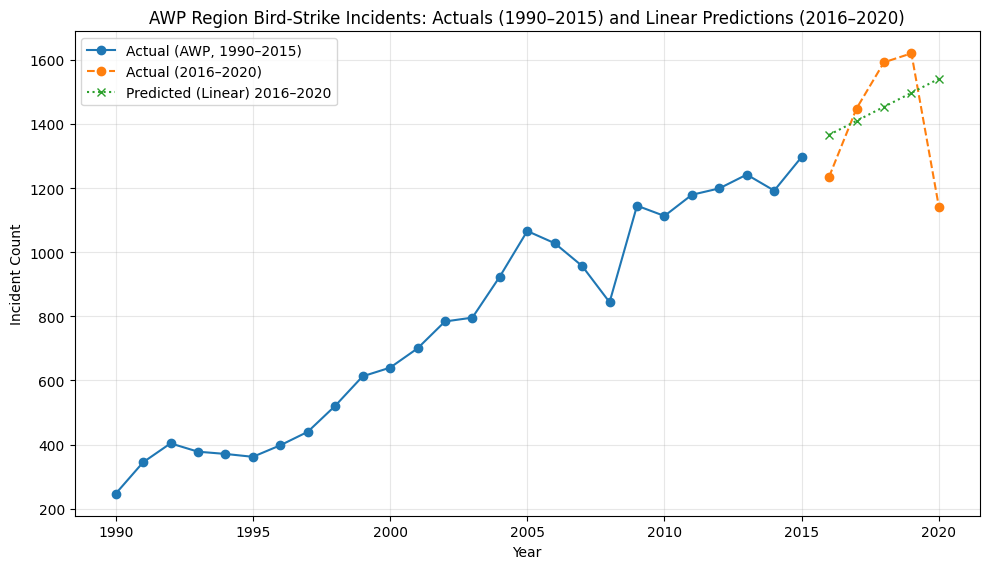

R-squared on training period 1990-2015: 0.9519

Predictions vs. actuals (2016–2020 when available):


,INCIDENT_YEAR,predicted_incidents,actual_incidents,abs_error,abs_pct_error
0,2016,1365.86,1235,130.86,10.60
1,2017,1409.52,1448,38.48,2.66
2,2018,1453.19,1592,138.81,8.72
3,2019,1496.86,1620,123.14,7.60
4,2020,1540.52,1142,398.52,34.90


In [42]:
# Q5: AWP Simple Linear Model

REGION_CODE = "AWP"
TRAIN_START, TRAIN_END = 1990, 2015
PRED_YEARS_MAIN = [2016, 2017]
PRED_YEARS_EXTRA = [2018, 2019, 2020]
SAVE_DIR = "outputs_q5"
os.makedirs(SAVE_DIR, exist_ok=True)

pd.set_option("display.float_format", lambda x: f"{x:.2f}")
df = data.copy()

if "INCIDENT_YEAR" not in df.columns:
    if "INCIDENT_DATE" in df.columns:
        parsed = pd.to_datetime(df["INCIDENT_DATE"], errors="coerce", infer_datetime_format=True)
        df["INCIDENT_YEAR"] = parsed.dt.year
    if "INCIDENT_YEAR" not in df.columns and "YEAR" in df.columns:
        df["INCIDENT_YEAR"] = pd.to_numeric(df["YEAR"], errors="coerce")
df["INCIDENT_YEAR"] = pd.to_numeric(df["INCIDENT_YEAR"], errors="coerce")

# FAA Region column
region_col = None
for c in ["FAAREGION", "FAA_REGION", "REGION"]:
    if c in df.columns:
        region_col = c
        break
if region_col is None:
    raise ValueError("Could not find FAA region column (expected FAAREGION / FAA_REGION / REGION).")

# filtering thru awp and aggregating the data
awp = df.loc[(df[region_col] == REGION_CODE) & df["INCIDENT_YEAR"].notna()].copy()
awp["INCIDENT_YEAR"] = awp["INCIDENT_YEAR"].astype(int)

awp_yearly = (
    awp.groupby("INCIDENT_YEAR", as_index=False)
    .size()
    .rename(columns={"size": "incidents"})
    .sort_values("INCIDENT_YEAR")
)

# train the data from 1990-2015
train = awp_yearly[(awp_yearly["INCIDENT_YEAR"] >= TRAIN_START) & (awp_yearly["INCIDENT_YEAR"] <= TRAIN_END)].copy()
if train.empty:
    raise ValueError("No AWP data between 1990 and 2015. Check your file/schema.")

X_train = train[["INCIDENT_YEAR"]].values
y_train = train["incidents"].values

lin = LinearRegression()
lin.fit(X_train, y_train)
r2 = float(lin.score(X_train, y_train))

# predict it from 2016-2020
pred_years = PRED_YEARS_MAIN + PRED_YEARS_EXTRA
X_pred = np.array(pred_years).reshape(-1, 1)
y_pred = lin.predict(X_pred)

pred_df = pd.DataFrame({"INCIDENT_YEAR": pred_years, "predicted_incidents": y_pred})

# merge with actual data if possible
compare = pred_df.merge(
    awp_yearly.rename(columns={"incidents": "actual_incidents"}),
    on="INCIDENT_YEAR",
    how="left"
)
compare["abs_error"] = (compare["actual_incidents"] - compare["predicted_incidents"]).abs()
compare["abs_pct_error"] = (compare["abs_error"] / compare["actual_incidents"]) * 100
compare_display = compare.copy()
for col in ["predicted_incidents", "actual_incidents", "abs_error", "abs_pct_error"]:
    compare_display[col] = compare_display[col].round(2)

# plotting
plt.figure(figsize=(10, 5.8))
# Actuals 1990–2015
plt.plot(train["INCIDENT_YEAR"], train["incidents"], marker="o", label="Actual (AWP, 1990–2015)")
# Actuals 2016–2020 (if present)
post = awp_yearly[awp_yearly["INCIDENT_YEAR"].between(2016, 2020)]
if not post.empty:
    plt.plot(post["INCIDENT_YEAR"], post["incidents"], marker="o", linestyle="--", label="Actual (2016–2020)")
# Predictions 2016–2020
plt.plot(pred_df["INCIDENT_YEAR"], pred_df["predicted_incidents"], marker="x", linestyle=":",
         label="Predicted (Linear) 2016–2020")

plt.title("AWP Region Bird-Strike Incidents: Actuals (1990–2015) and Linear Predictions (2016–2020)")
plt.xlabel("Year")
plt.ylabel("Incident Count")
plt.grid(True, alpha=0.3)
plt.legend()
fig_path = os.path.join(SAVE_DIR, "q5_awp_linear_model.png")
plt.tight_layout()
plt.savefig(fig_path, dpi=180)
plt.show()

# ---------- SAVE ARTIFACTS ----------
train.to_csv(train_path, index=False)
compare_display.to_csv(pred_path, index=False)
awp_yearly.to_csv(awp_yearly_path, index=False)

print(f"R-squared on training period {TRAIN_START}-{TRAIN_END}: {r2:.4f}\n")
print("Predictions vs. actuals (2016–2020 when available):")
display(compare_display)


We modeled annual bird-strike incidents in the AWP region using a simple linear regression with Year as the only predictor, trained on 1990–2015 data. The model fit the training period very well, with an R² of 0.9519, which means about 95% of the variation in incidents during those years is explained by a straight-line trend over time. Using that model, the predictions for 2016–2020 were: 2016 = 1365.86, 2017 = 1409.52, 2018 = 1453.19, 2019 = 1496.86, and 2020 = 1540.52 incidents.

Comparing to actuals, 2016 had 1235 incidents (10.60% error) and 2017 had 1448 incidents (2.66% error), so the model tracked 2017 closely and slightly over-predicted 2016. It under-predicted 2018 (1592 actual, 8.72% error) and 2019 (1620 actual, 7.60% error), because those years came in above the straight-line trend. It over-predicted 2020 by a lot (1142 actual vs 1540.52 predicted, 34.90% error), reflecting the pandemic shock that a simple trend model can’t anticipate.

Overall, the linear model is good for summarizing the long-run upward pattern and gives okay short-term extrapolations in stable conditions, but it becomes unreliable when conditions change. For practical forecasting, we would need to include additional drivers like flight volume, seasonality, and known disruptions, rather than relying on a single-variable linear trend.

Question 7 — OPTIONAL (10 points)

This optional bonus question requires that you perform a geospatial analysis on bird strikes and visualize the results using a map. Examples include (but you are not limited to):

Mapping bird strike incidents: visualize the locations of bird strike incidents to identify hot spots or patterns
Heat maps: create heat maps to show the density of bird strike incidents in different areas.
Proximity Analysis: analyze the proximity of bird strikes to airports or landmarks
etc
Ensure that you clearly indicate the analysis that you are performing and provide detailed steps to explain ALL findings from your analysis.

Note: a thorough analysis that demonstrates multiple patterns is required to earn full credit for this question.